In [40]:
from pyspark import SparkContext
import csv
from pyspark.sql import SparkSession
from pyspark.sql.context import SQLContext
from pyspark.sql.functions import col
from datetime import datetime
from pyspark.mllib.clustering import BisectingKMeans
import pandas as pd
import numpy as np
import re
import ast
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as spclust
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
#local spark
sc = SparkContext(appName="Clusters")
#sqlc = SQLContext(sc)
#vocareum
#sc = spark.sparkContext

In [3]:
def read_tracks():
        tracks = pd.read_csv("tracks.csv", index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


In [4]:
def read_features():
     return pd.read_csv("features.csv", index_col=0, header=[0, 1, 2])

In [5]:
data = read_tracks()#data = data.map(lambda line: line.split(",")).filter(lambda v: v[0]!="START")
data = data[data['set','subset']=='small']
#data.iloc[:,0:0]
subset_ids = [i for i in data.index]

In [6]:
subset_ids
#features=read_features()
#features[small]

[2,
 5,
 10,
 140,
 141,
 148,
 182,
 190,
 193,
 194,
 197,
 200,
 203,
 204,
 207,
 210,
 211,
 212,
 213,
 255,
 256,
 368,
 424,
 459,
 534,
 540,
 546,
 574,
 602,
 615,
 620,
 621,
 625,
 666,
 667,
 676,
 690,
 694,
 695,
 704,
 705,
 706,
 707,
 708,
 709,
 714,
 715,
 716,
 718,
 777,
 814,
 821,
 822,
 825,
 853,
 890,
 892,
 897,
 993,
 995,
 997,
 998,
 1039,
 1040,
 1066,
 1069,
 1073,
 1075,
 1082,
 1083,
 1087,
 1102,
 1193,
 1195,
 1196,
 1197,
 1249,
 1259,
 1270,
 1276,
 1277,
 1278,
 1417,
 1427,
 1443,
 1482,
 1510,
 1544,
 1642,
 1644,
 1649,
 1661,
 1663,
 1666,
 1673,
 1680,
 1681,
 1682,
 1683,
 1684,
 1685,
 1686,
 1687,
 1688,
 1689,
 1701,
 1702,
 1703,
 1704,
 1706,
 1720,
 1732,
 1733,
 1735,
 1736,
 1883,
 1891,
 1893,
 1924,
 1925,
 1929,
 1930,
 2012,
 2096,
 2097,
 2099,
 3263,
 3264,
 3265,
 3266,
 3270,
 3271,
 3272,
 3273,
 3274,
 3492,
 3532,
 3533,
 3534,
 3535,
 3537,
 3538,
 3573,
 3598,
 3624,
 3707,
 3708,
 3720,
 3721,
 3722,
 3724,
 3725,
 37

In [7]:
feature_data = read_features()
feature_data

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   
...                ...       ...       ...       ...       ...       ...   
155316       -0.490129  0.463834  2.321970 -0.084352  1.662914  2.115189   
155317       -0.461559 -0.229601 -0.496632 -0.422033  0.130612 -0.263825   
155318        0.552473 -0.110498 -0.532014  0.263131 -0.224011 -0.530972   
155319       -0.176901  0.187208 -0.050664  0.368843  0.066005 -0.857354   
155320        0.489665  1.862421  0.854461 -0.103666 -0.249835  0.360283   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   
...              ...       ...       ...       ...  ...       ...       ...   
155316     -0.237794  5.695442  0.830353  1.951819  ...  0.128410  0.022547   
155317     -0.628103 -0.082687 -0.229483 -0.492753  ...  0.132964  0.023548   
155318      1.713526  1.418444  1.325197  0.120333  ...  0.108324  0.017540   
155319     -0.780860  0.626281 -0.630938 -0.787229  ...  0.088311  0.018328   
155320     -0.366701  0.033578 -0.834606 -1.154845  ...  0.091421  0.020312   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   
...              ...        ...       ...       ...       ...       ...   
155316      0.019816   4.448255  0.172852  0.028773  0.028320  0.003906   
155317      0.026527   3.270612  0.196289  0.031116  0.027832  0.002441   
155318      0.020471   2.356727  0.212891  0.038450  0.037109  0.003418   
155319      0.017936   6.188604  0.167480  0.041480  0.038086  0.004883   
155320      0.016794  21.756050  0.845215  0.075141  0.044434  0.004395   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  
...              ...       ...  
155316      0.955388  0.012385  
155317      1.283060  0.019059  
155318      0.828569  0.017904  
155319      1.818740  0.020133  
155320      4.687204  0.137205  

[106574 rows x 518 columns]

In [8]:
features = sc.textFile("features.csv")
useless = features.take(4)
useless


['feature,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma_cens,chroma

In [9]:
filtered_features = features.filter(lambda a : not a in useless).map(lambda a : (int(a[0]),[float(i) for i in a.split(",")[1:]])).filter(lambda a: a[0] in subset_ids )
filtered_features.take(10)

[(2,
  [7.1806526184,
   5.2303090096,
   0.24932080507,
   1.3476201296,
   1.4824777842,
   0.53137123585,
   1.4815930128,
   2.691454649,
   0.86686819792,
   1.3412306309,
   1.3477915525,
   1.2376583815,
   0.69249993563,
   0.56934404373,
   0.59704089165,
   0.62586373091,
   0.56732958555,
   0.44394925237,
   0.48797628284,
   0.49732723832,
   0.57443547249,
   0.57924067974,
   0.62010246515,
   0.58694541454,
   0.47430026531,
   0.36981594563,
   0.23611885309,
   0.22806788981,
   0.22282999754,
   0.22141483426,
   0.2292380482,
   0.24879531562,
   0.19624517858,
   0.17580920458,
   0.20071266592,
   0.31997194886,
   0.48282524943,
   0.38765248656,
   0.24908207357,
   0.23818692565,
   0.23306615651,
   0.23012046516,
   0.23206828535,
   0.24889595807,
   0.19769220054,
   0.17329964042,
   0.19883966446,
   0.31405305862,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   -1.9959007502,
   -1.8116534948,
   -0.3518

In [10]:
pd_features = read_features()

In [11]:
pd_features

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   
...                ...       ...       ...       ...       ...       ...   
155316       -0.490129  0.463834  2.321970 -0.084352  1.662914  2.115189   
155317       -0.461559 -0.229601 -0.496632 -0.422033  0.130612 -0.263825   
155318        0.552473 -0.110498 -0.532014  0.263131 -0.224011 -0.530972   
155319       -0.176901  0.187208 -0.050664  0.368843  0.066005 -0.857354   
155320        0.489665  1.862421  0.854461 -0.103666 -0.249835  0.360283   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   
...              ...       ...       ...       ...  ...       ...       ...   
155316     -0.237794  5.695442  0.830353  1.951819  ...  0.128410  0.022547   
155317     -0.628103 -0.082687 -0.229483 -0.492753  ...  0.132964  0.023548   
155318      1.713526  1.418444  1.325197  0.120333  ...  0.108324  0.017540   
155319     -0.780860  0.626281 -0.630938 -0.787229  ...  0.088311  0.018328   
155320     -0.366701  0.033578 -0.834606 -1.154845  ...  0.091421  0.020312   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   
...              ...        ...       ...       ...       ...       ...   
155316      0.019816   4.448255  0.172852  0.028773  0.028320  0.003906   
155317      0.026527   3.270612  0.196289  0.031116  0.027832  0.002441   
155318      0.020471   2.356727  0.212891  0.038450  0.037109  0.003418   
155319      0.017936   6.188604  0.167480  0.041480  0.038086  0.004883   
155320      0.016794  21.756050  0.845215  0.075141  0.044434  0.004395   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  
...              ...       ...  
155316      0.955388  0.012385  
155317      1.283060  0.019059  
155318      0.828569  0.017904  
155319      1.818740  0.020133  
155320      4.687204  0.137205  

[106574 rows x 518 columns]

In [12]:
pd_small_subset  = pd_features[pd_features.index.isin(subset_ids)]

In [13]:
pd_small_subset

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
140           0.533579 -0.623885 -1.086205 -1.081079 -0.765151 -0.072282   
141           0.172898 -0.284804 -1.169662 -1.062855 -0.706868 -0.708281   
...                ...       ...       ...       ...       ...       ...   
154308       -0.677709 -0.830608 -0.686122  0.185158  2.854806 -1.131797   
154309       -0.585059 -0.635075 -0.194742 -0.434809 -1.357310 -0.257745   
154413       -0.214509 -1.130469  0.718534 -0.368448 -0.147830 -0.099409   
154414       -0.487371 -0.923754 -0.283099 -0.435221 -1.137329 -0.798039   
155066        0.044216 -0.300441 -0.217022 -0.356106 -1.085789 -1.185135   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
140        -0.882913 -0.582376 -0.884749 -0.645214  ...  0.157683  0.028070   
141        -0.204884  0.023624 -0.642770 -0.786291  ...  0.145994  0.024342   
...              ...       ...       ...       ...  ...       ...       ...   
154308     -1.161222 -1.110237 -0.818111 -1.388484  ...  0.117287  0.021906   
154309     -0.639082 -0.572640 -1.225242  5.548715  ...  0.180397  0.029303   
154413     -1.325709 -0.105248 -1.363881  1.229534  ...  0.156587  0.036926   
154414     -0.258168  1.004049 -0.499121  0.746973  ...  0.181294  0.026723   
155066     -0.655948 -1.517006 -0.490595 -1.267883  ...  0.189816  0.029439   

feature                      zcr                                          \
statistics              kurtosis       max      mean    median       min   
number            06          01        01        01        01        01   
track_id                                                                   
2           0.012111    5.758890  0.459473  0.085629  0.071289  0.000000   
5           0.014759    6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921   21.434212  0.452148  0.077515  0.071777  0.000000   
140         0.025946   11.052547  0.379395  0.052379  0.036621  0.001953   
141         0.032111   32.994659  0.415527  0.040267  0.034668  0.002930   
...              ...         ...       ...       ...       ...       ...   
154308      0.021999   53.807804  0.769043  0.042997  0.022949  0.001953   
154309      0.023771   12.597441  0.768555  0.082979  0.037109  0.008789   
154413      0.038113   25.368595  0.323242  0.024532  0.018066  0.000977   
154414      0.030980   21.276468  0.511230  0.046116  0.033691  0.003418   
155066      0.025806  116.044044  0.554199  0.016058  0.009766  0.000000   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
5           2.193303  0.044861  
10          3.542325  0.040800  
140         3.143968  0.057712  
141         4.204097  0.028665  
...              ...       ...  
154308      6.928385  0.084298  
154309      3.441251  0.129480  
154413      3.736646  0.023821  
154414      3.997052  0.045733  
155066      9.688635  0.030787  

[8000 rows x 518 columns]

Text(0, 0.5, 'Euclidean distance')

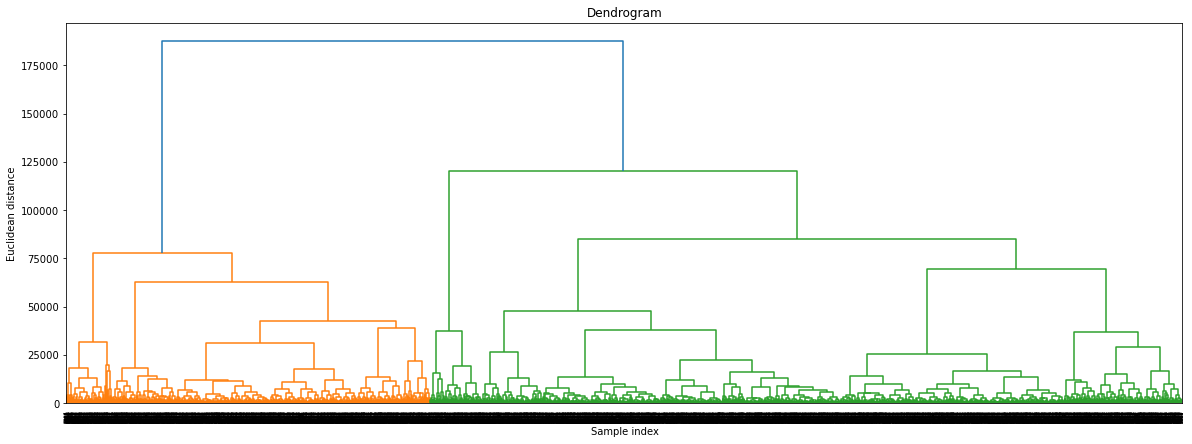

In [14]:
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
spclust.dendrogram(spclust.linkage(pd_small_subset, method='ward'))

plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')

In [104]:
def get_stats(all_entries,labels,k):
    all_clusters = get_all_clusters(all_entries, labels, k)
    p=0
    radius_list=[]
    density_list=[]
    for cluster in all_clusters:
      
        centroid = get_cluster_centroid(cluster)
        radius=get_cluster_radius(cluster,centroid)
        #diameter = get_cluster_diameter(cluster)
        density = len(cluster)/(radius**2)
        radius_list.append(radius)
        density_list.append(density)
        #print("cluster ",p,"\nradius: " + str(radius) + "\ndiameter: " + str(diameter) + "\ndensity: " + str(density))
        #print("cluster ",p,"\nradius: " + str(radius) +  "\ndensity: " + str(density))
        p+=1
    print("average radius: ",sum(radius_list)/len(radius_list))
    print("average density: ",sum(density_list)/len(density_list))

In [65]:
def get_clusters(entries, labels, i):
    cluster_i = np.array([entries[j] for j in range(len(labels)) if labels[j]==i])
    return cluster_i

    

In [67]:
def get_all_clusters(entries, labels, k):
    all_clusters = []
    for i in range(k):
        all_clusters.append(get_clusters(entries, labels, i))
    return all_clusters #np.array(all_clusters)

In [84]:
def get_cluster_centroid(values):
    return np.mean(values,axis=0)

In [88]:
def get_cluster_radius(values, centroid):
    
    max_dist=0
    for i in range(len(values)):
       #maybe vectorize
      
        dist = distance.euclidean(values[i],centroid)
        if dist > max_dist:
            max_dist = dist
    return max_dist

In [90]:
def get_cluster_diameter(values):
    max_dist=0
    for i in range(len(values)):
        for j in range(i+1,len(values)):
            dist = distance.euclidean(values[i],values[j])
            if dist > max_dist:
                max_dist = dist
    return max_dist

In [106]:
min_clusters = 8
#max_clusters = min_clusters
max_clusters = 16
for k in range(min_clusters,max_clusters+1):
    cluster = AgglomerativeClustering(
        n_clusters=k, affinity='euclidean', linkage='ward')

    cluster.fit(pd_small_subset)
    labels = cluster.labels_
    print("for ",k," clusters");
    #print(labels)
    
    #k_clusters = pd_small_subset.copy()
    
    np_clusters = pd_small_subset.to_numpy()    
 
    get_stats(np_clusters, labels, k)

for  8  clusters
average radius:  4602.602032677836
average density:  7.962116015409431e-05
for  9  clusters
average radius:  4336.640762529928
average density:  8.468280174708502e-05
for  10  clusters
average radius:  4021.3657071620632
average density:  8.164135739606748e-05
for  11  clusters
average radius:  3960.9704922260457
average density:  7.530015533838524e-05
for  12  clusters
average radius:  3737.6028338233227
average density:  7.083319800111052e-05
for  13  clusters
average radius:  3618.4576084409473
average density:  6.755265585371378e-05
for  14  clusters
average radius:  3494.971319772689
average density:  6.402566164660507e-05
for  15  clusters
average radius:  3365.63895203218
average density:  6.715938168255904e-05
for  16  clusters
average radius:  3303.1946395190002
average density:  6.424864539260668e-05
